In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
fname = "kay_images.npz"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/ymnjv/download

In [ ]:
with np.load(fname) as dobj:
    dat = dict(**dobj)

In [ ]:
print(dat.keys())

dict_keys(['stimuli', 'stimuli_test', 'responses', 'responses_test', 'roi', 'roi_names'])


`dat` has the following fields:
    - `stimuli`: stim x i x j array of grayscale stimulus images
    - `stimuli_test`: stim x i x j array of grayscale stimulus images in the test set
    - `responses`: stim x voxel array of z-scored BOLD response amplitude
    - `responses_test`:  stim x voxel array of z-scored BOLD response amplitude in the test set
    - `roi`: array of voxel labels
    - `roi_names`: array of names corresponding to voxel labels

In [ ]:
print(dat["stimuli"].shape)

(1750, 128, 128)


    The stimuli (used for training...?) is 128x128 grayscale images, 1750 count. 
    This also seems to be the array called by compscript.m to produce the proj matrix.
    The matlab code also calls for a matrix gab, given by gaborfit.m which calls gabor_fn.m, which requires (theta,lambda,psi,gamma,x0,y0)

In [ ]:
print(dat["responses"].shape)

(1750, 8428)


    This seems to be (# images, fMRI data over time?). I wonder what the timestep is?

In [ ]:
print(dat["stimuli_test"].shape)

(120, 128, 128)


    There are only 120 128x128 grayscale images used for the testing. 

In [ ]:
print(dat["responses_test"].shape)

(120, 8428)


    Same number of images as the stimuli_test, as expected. 
    Same other length as the training responses, so... 
    I imagine its the fMRI data for each image, like a brain snapshot rather than over time...?

    Checked further down, it is the BOLD responses after seeig each image, and it is graphed down below. 
    Well, as in the "responses" are graphed below, not "responses_test".
    Actually, both are plotted below! And that's about it. Not much here, at least in comparison to HCP

This is the number of voxels in each ROI. Note that `"Other"` voxels have been removed from this version of the dataset:

In [ ]:
dict(zip(dat["roi_names"], np.bincount(dat["roi"])))

{'LatOcc': 928,
 'Other': 0,
 'V1': 1294,
 'V2': 2083,
 'V3': 1790,
 'V3A': 484,
 'V3B': 314,
 'V4': 1535}

*This basically counts the number of voxels in each ROI, which was done by the last section in compscript.m.*
*Also seems that the matlab code may have had access to all the data, and expected to have the "other" areas included, which we do not.*

Each stimulus is a 128 x 128 grayscale array:

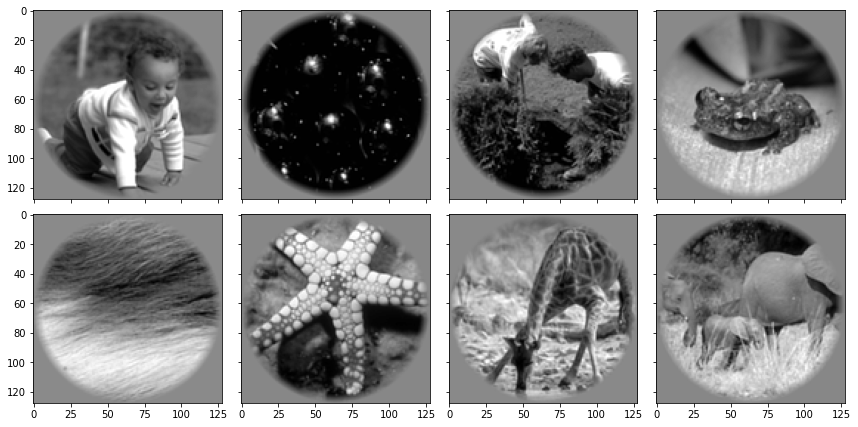

In [ ]:
f, axs = plt.subplots(2, 4, figsize=(12, 6), sharex=True, sharey=True)
for ax, im in zip(axs.flat, dat["stimuli"]):
  ax.imshow(im, cmap="gray")
f.tight_layout()

Each stimulus is associated with a pattern of BOLD response across voxels in visual cortex:

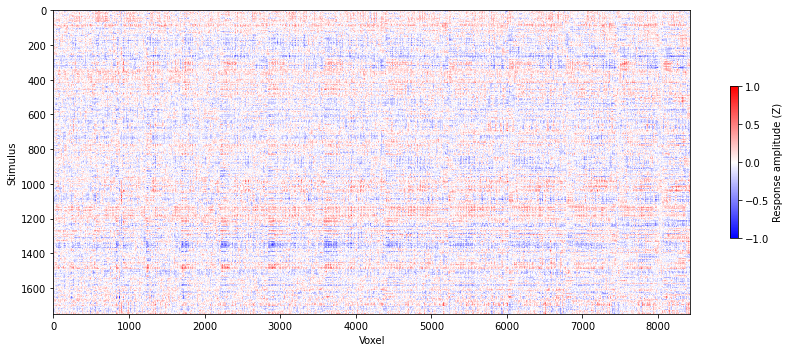

In [ ]:
f, ax = plt.subplots(figsize=(12, 5))
ax.set(xlabel="Voxel", ylabel="Stimulus")
heatmap = ax.imshow(dat["responses"], aspect="auto", vmin=-1, vmax=1, cmap="bwr")
f.colorbar(heatmap, shrink=.5, label="Response amplitude (Z)")
f.tight_layout()

The training/validation splits from the original paper are retained, so the 120 test stimuli and responses are in separate data structures:

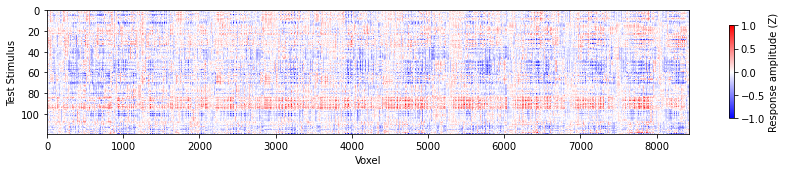

In [ ]:
f, ax = plt.subplots(figsize=(12, 2.5))
ax.set(xlabel="Voxel", ylabel="Test Stimulus")
heatmap = ax.imshow(dat["responses_test"], aspect="auto", vmin=-1, vmax=1, cmap="bwr")
f.colorbar(heatmap, shrink=.75, label="Response amplitude (Z)")
f.tight_layout()

---
# Begining of my attempt to translate the matlab version to python

In [ ]:
# gab = np.zeros([128,128,5456])
# gab.shape
# # range(0,7*22.5+1,22.5)
# ang_rang = [0, 22.5000, 45.0000, 67.5000, 90.0000, 112.5000, 135.0000, 157.5000]
# ang_rang
# test = range(1,5457,2)
# len(test)
# # test[-1]
# np.cos(0)
# np.sin(np.pi)
# np.exp(1)
# 7e-2
# ygrid = range(-63,65)
# xgrid = range(-63,65)
# x, y =np.meshgrid(xgrid,ygrid)
# x
gab = gaborfit()
len(gab)
j = 45
plt.imshow(gab[:,:,j])
print(gab[:,:,j])
print(np.max(gab[:,:,j]))

gaborfit.py runs without issue

gabor_fn.py runs without issue

paintgen.py runs without issue (not tested with data)

linerreg.py runs without issue (not tested with data)

gabpara.py runs without issue (not tested with data, contributed by Na)

gabdelete.py runs without issue (not tested with data, contributed by Na)

inittrain.py runs without issue (not tested with data)

gabor_field.py runs without issue (not tested with data)

rsquare.py runs without issue (not tested with data)

travoxmdl.py runs without issue (not tested with data)

In [ ]:
# @title gaborfit: needs to be updatated with Danny's working version
def gaborfit():
# % produce a set of gabor wavelet directly
    ang_rang = [0, 22.5000, 45.0000, 67.5000, 90.0000, 112.5000, 135.0000, 157.5000]
    gab = np.zeros([128,128,5456+1])
    count = 1
    m = 1
    for i in range(1,6): #=1:5
        FOV = 2**(i-1)
        '''
        Spatial frequency tuning - goes through 1-5, producing FOV = 1,2,4,8,16
        '''
        lmbda = 128 / FOV
        if FOV == 2:
            x0 = -32
            y0 = x0
        elif FOV == 4:
            x0 = -48
            y0 = x0
        elif FOV == 8:
            x0 = -56 
            y0 = -56 
        elif FOV == 1:
            x0 = 0 
            y0 = 0 
        else:
            x0 = -60 
            y0 = -60 

        for angle in ang_rang: #range(0,7*22.5+1,22.5)
            for j in range(FOV): #=0:FOV-1:
                for k in range(FOV): #=0:FOV-1:
                    gab[:,:,count]=gabor_fn(angle,lmbda,0,1,x0+j*lmbda,y0+k*lmbda);
                    count += 1
                    gab[:,:,count]=gabor_fn(angle,lmbda,180,1,x0+j*lmbda,y0+k*lmbda);
                    count += 1
                    m += 1
    return gab

In [ ]:
# @title gabor_fn: needs to be updated with Danny's working version
def gabor_fn(theta,lmbda,psi,gamma,x0=0,y0=0):
# % produce a gabor wavelet for the given sf,angle,phase,posi

    sigma = lmbda / 2
    sigma_x = sigma
    sigma_y = sigma / gamma
    # % Bounding box

    # %[x,y] = meshgrid(xmin:xmax,ymin:ymax);
    ygrid = range(-63,65)
    xgrid = range(-63,65)
    x, y =np.meshgrid(xgrid,ygrid)             #-63:64,-63:64);
    # % Rotation
    theta = 2 * np.pi * theta / 360
    psi = 2 * np.pi * psi / 360
    x = x - x0
    y = y - y0
    x_theta = x * np.cos(theta) + y * np.sin(theta)
    y_theta = -x * np.sin(theta) + y * np.cos(theta)

    gb = np.exp(-.5*(x_theta**2/sigma_x**2 + y_theta**2/sigma_y**2))*\
                np.cos(2*np.pi/(lmbda*x_theta+psi))

    # print(len(gb))
    
    # for k in range(len(gb)):
    #   #if np.all(gb[k] < 1e-5, gb[k] > -1e-5):
    #   if gb[k] < 1e-5:
    #     if gb[k] > -1e-5:
    #       gb[k] = 0
    
    # how to fix this...?
    # gbto0 = gb.all(gb<1e-5)
    # gb[gbto0] = 0
    # gbto0 = gb.all(gb>-1e-5)
    # gb[gbto0] = 0
    
    # %size(x);
    # %imshow(gb,[]);
    return gb

In [ ]:
# @title gabpara:
def gabpara():
# generate gabor parameter of gabor fit model
# columns are same with that in the projection matrix
# angles are in rows
# x position
# y position

    gabpara=np.zeros((5,1864))
    FOV=[2**(i-1) for i in range(1,6)]        # FOV is a 5 element list
    lmbda=[128/j for j in FOV]                # lmbda is a 5 element list
    angle=[np.arange(0,7*22.5+1,22.5)]
    count=1
    for i in range(len(FOV)):
        if i==0: 
          x0,y0=0,0 
          # print('FOV=', FOV[i], 'x0=',x0,'y0=', y0)
        elif i==1: 
          x0,y0=-32,x0 
          # print('FOV=', FOV[i], 'x0=',x0,'y0=', y0)
        elif i==2: 
          x0,y0=-48,x0
          # print('FOV=', FOV[i], 'x0=',x0,'y0=', y0)
        elif i==3: 
          x0,y0=-56,-56
          # print('FOV=', FOV[i], 'x0=',x0,'y0=', y0)
        else: 
          x0,y0=-60,-60
          # print('FOV=', FOV[i], 'x0=',x0,'y0=', y0)
        for m in range(len(angle)):       
            pp=1
            for j,k in FOV:
                temp=sqrt((x0+j*lmbda)^2+(y0+k*lmbda)^2)
                if temp>60:
                    projaf=[projaf[:,1:(count-1)],projaf[:,(count+1)::]]
                else:
                    x=x0+j*lmbda
                    y=y0+k*lmbda
                    gabpara[1,count]=angle[m]
                    gabpara[2,count]=FOV[j]
                    gabpara[3,count]=x0+j*lmbda
                    gabpara[4,count]=y0+k*lmbda
                    gabpara[5,count]=pp
                    count+=1
                    pp+=1
        return gabpara

In [ ]:
# @title gabdelete: deletes gabor patch out of the boundary of visual field, may need update
def gabdelete(proj): 
#  delete the gabor patch that out of the boundary of the visual field
    projaf=proj
    FOV=[2**(i-1) for i in range(1,6)]        # FOV is a 5 element list
    lmbda=[128/j for j in FOV]                # lmbda is a 5 element list
    angle=[np.arange(0,7*22.5+1,22.5)]
    count=1
    for i in range(len(FOV)):
        if i==0: 
          x0,y0=0,0 
          # print('FOV=', FOV[i], 'x0=',x0,'y0=', y0)
        elif i==1: 
          x0,y0=-32,x0 
          # print('FOV=', FOV[i], 'x0=',x0,'y0=', y0)
        elif i==2: 
          x0,y0=-48,x0
          # print('FOV=', FOV[i], 'x0=',x0,'y0=', y0)
        elif i==3: 
          x0,y0=-56,-56
          # print('FOV=', FOV[i], 'x0=',x0,'y0=', y0)
        else: 
          x0,y0=-60,-60
          # print('FOV=', FOV[i], 'x0=',x0,'y0=', y0)
          for m in angle:       
              pp=1
              for j,k in FOV:
                  temp=sqrt((x0+j*lmbda)**2+(y0+k*lmbda)**2) # the distance from the center of two grids
                  if temp>60:           # delete the gabor patch that out of this
                      projaf=[projaf[:,1:(count-1)],projaf[:,(count+1)::]]
                  else:
                    count+=1         # display the process
    return projaf

In [ ]:
# @title linerreg: Needs to be updated...? liner regression function w/ early stopping gradient
def linerreg( X,Y,Xst,Yst ):
# %liner regression function with the early stopping gradint descent
# %   Y=Xh...Xst,Yst is the stopping set
    count = 0
    p = np.size(X,0)      #size(X,1); # p here never shows up...????
    q = np.size(X,1)      #size(X,2);
    h = np.zeros(q,1)  # should this be (p,1)?
    g = np.zeros(q,1)
    RMSE = 100
    RMSEaf = 99
    RMSEres = 100
    RMSEresaf = 99
    R2 = 0
    R2st = 0
    while (RMSEaf<RMSE and RMSEresaf<RMSEres):
        RMSE = RMSEaf
        RMSEres = RMSEresaf
        # %h=h-0.001*g;
        g = (X@(X*h-Y)) / np.linalg.norm(X@(X*h-Y)) + 0.9*g #%eraly stopping grandint descent
        # %g=(X'*(X*h-Y));
        h = h - 0.001 * g
        Ystp = Xst * h
        Yrep = X * h
        [R2,RMSEaf]=rsquare(Yst,Ystp)
        [R2st,RMSEresaf]=rsquare(Y,Yrep)
        count += 1
        if count > 1500:
            break

    # %fprintf('num:%d devist:%.4f devi :%.4f R2:%.4f R2st:%.4f\n',count,RMSEaf,RMSEresaf,R2,R2st);%display the num&devi

    return [ h,RMSEaf,RMSEresaf,R2,R2st,count ]

In [ ]:
# @title inittrain: calls linerreg, goes voxel-by-voxel. Does the training...?
def inittrain(proj,dataTrnS1,i):
    # %UNTITLED Summary of this function goes here
    # % proj--->x
    # % dataTrnS1(i,1:1400)----->Y
    # % dataTrnS1(i,1401:1750)---->Yst
    # % i---->num of the target voxel
    # % for a single voxels
    p = 1550
    q = np.size(proj,1) #size(proj,2);
    Y = dataTrnS1[i,1:p]
    Ycnannum = []

    for k in range(1,p+1):
        if not np.isnan(Y(k)): #~isnan(Y(k))
            Ycnannum = [Ycnannum,k] #% figure out the nan element

    Y = Y(Ycnannum) #%exclude the nan element
    X = proj 
    Xst = X[(p+1):(np.size(proj,0)+1),:]
    Xst = [np.ones(size(proj,1)-p,1),Xst]
    X = X[1:p,:]
    h = np.zeros(q+1,1)
    Ys = Y - np.mean(Y)
    Ys = Ys.T
    Xp = np.zeros(p,q)

    for j in range (1,q+1): #=1:q
        Xp[:,j] = (X[:,j] - np.mean(X[:,j]) ) / np.std(X[:,j])

    Xp[np.isnan(Xp)] = 0
    Xp = [np.ones(p,1),Xp]
    Xp = Xp[Ycnannum,:]   
    Yst = dataTrnS1[i, (p+1):size(proj,1)]
    Ystcnannum = []

    for k in range(1,np.size(proj,0)-p+1):  #=1:size(proj,1)-p
        if not np.isnan(Yst(k)):
            Ystcnannum = [Ystcnannum,k]

    Yst = Yst(Ystcnannum).T
    Xst = Xst[Ystcnannum,:]
    h,RMSEaf,RMSEresaf,R2,R2st,count = linerreg(Xp,Ys,Xst,Yst) #% liner regression function
    # %fprintf('num:%d devist:%.4f devi :%.4f R2:%.4f R2st:%.4f\n',count,RMSEaf,RMSEresaf,R2,R2st);
    h[2:end] /= np.std(X)                 # h(2:end)=h(2:end)./std(X)';
    h[np.isnan(h)] = 0

    return [ h,RMSEaf,RMSEresaf,R2,R2st,count ]

In [ ]:
# @title gabor_field: needs to be updated to Danny's version
def gabor_field(lmbda,x0=0,y0=0):
# % produce the field of the gabor wavelet for the given sf,angle,phase,posi
    gamma = 1
    sigma = lmbda/2 
    sigma_x = sigma
    sigma_y = sigma/gamma
    # % Bounding box

    # %[x,y] = meshgrid(xmin:xmax,ymin:ymax);
    ygrid = range(-63,65)
    xgrid = range(-63,65)
    x, y =np.meshgrid(xgrid,ygrid)
    # [x,y]=meshgrid(-63:64,-63:64);
    # % Rotation
    x -= x0      #=x-x0;
    y -= y0      #=y-y0;

    gb = np.exp(-.5*(x**2/sigma_x**2 + y**2/sigma_y**2))
    
    # looks like this requires the same move to 1d, make things zero in a 
    # certain range, and move back to 2d
    gb[gb<1e-3 & gb>-1e-3] = 0
    # %size(x);
    # %imshow(gb,[-1,1]); 
    gf = gb
    return gf

In [ ]:
# @title paintgen: calls inittrain, gabor_field
def paintgen(projavged,dataTrnS1,posi,i):
    [h,RMSEaf,RMSEresaf,R2,R2st,count]  = inittrain(projavged,dataTrnS1,i)
    pic = np.zeros(128,128)
    for k in range(1,233+1):
        gf = gabor_field(posi(3,k),posi(1,k),posi(2,k))  #% make RF map
        pic = pic + gf*abs(h(k+1))

    pic /= 233
    return pic

In [ ]:
# @title rsquare: Compute coefficient of determination of data fit model and RMSE
def rsquare(y,f,varargin=True):
    # % Compute coefficient of determination of data fit model and RMSE
    # %
    # % [r2 rmse] = rsquare(y,f)
    # % [r2 rmse] = rsquare(y,f,c)
    # %
    # % RSQUARE computes the coefficient of determination (R-square) value from
    # % actual data Y and model data F. The code uses a general version of 
    # % R-square, based on comparing the variability of the estimation errors 
    # % with the variability of the original values. RSQUARE also outputs the
    # % root mean squared error (RMSE) for the user's convenience.
    # %
    # % Note: RSQUARE ignores comparisons involving NaN values.
    # % 
    # % INPUTS
    # %   Y       : Actual data
    # %   F       : Model fit
    # %
    # % OPTION
    # %   C       : Constant term in model
    # %             R-square may be a questionable measure of fit when no
    # %             constant term is included in the model.
    # %   [DEFAULT] TRUE : Use traditional R-square computation
    # %            FALSE : Uses alternate R-square computation for model
    # %                    without constant term [R2 = 1 - NORM(Y-F)/NORM(Y)]
    # %
    # % OUTPUT 
    # %   R2      : Coefficient of determination
    # %   RMSE    : Root mean squared error
    # %
    # % EXAMPLE
    # %   x = 0:0.1:10;
    # %   y = 2.*x + 1 + randn(size(x));
    # %   p = polyfit(x,y,1);
    # %   f = polyval(p,x);
    # %   [r2 rmse] = rsquare(y,f);
    # %   figure; plot(x,y,'b-');
    # %   hold on; plot(x,f,'r-');
    # %   title(strcat(['R2 = ' num2str(r2) '; RMSE = ' num2str(rmse)]))
    # %   
    # % Jered R Wells
    # % 11/17/11
    # % jered [dot] wells [at] duke [dot] edu
    # %
    # % v1.2 (02/14/2012)
    # %
    # % Thanks to John D'Errico for useful comments and insight which has helped
    # % to improve this code. His code POLYFITN was consulted in the inclusion of
    # % the C-option (REF. File ID: #34765).

    # By setting varargin as True by default, I think this loop is unnescessary
    # if isempty(varargin); 
    #     c = True; 
    # elif length(varargin)>1; 
    #     error 'Too many input arguments';
    # elif ~islogical(varargin{1}); 
    #     error 'C must be logical (TRUE||FALSE)'
    # else: 
    #     c = varargin{1}; 


    # % Compare inputs
    if (np.size(y) != np.size(f)):      #~all(size(y)==size(f)); 
        sys.exit('Y and F must be the same size')

    # % Check for NaN
    tmp = not (np.isnan(y) or np.isnan(f))   # ~or(isnan(y),isnan(f));
    y = y(tmp)
    f = f(tmp)

    if c: 
        r2 = max(0, ( (1 - np.sum((y[:]-f[:])**2) ) / (np.sum( (y[:]- np.mean(y[:])**2) ) ) ))
    else: 
        r2 = 1 - np.sum((y[:]-f[:])**2) / np.sum((y[:])**2) 
        if r2 < 0:
        # % http://web.maths.unsw.edu.au/~adelle/Garvan/Assays/GoodnessOfFit.html
            #warning('Consider adding a constant term to your model') #ok<WNTAG>
            r2 = 0


    rmse = np.sqrt( np.mean( (y[:] - f[:])**2 ) )

    return r2,rmse

In [8]:
# @title travoxmdl: I think Danny has an improved version of this...? Also seems to have some redundancy w/other programs (not sure which)
def travoxmdl(proj,dataTrnS1,i):
    # % proj--->x
    # % dataTrnS1(i,1:1400)----->Y
    # % dataTrnS1(i,1401:1750)---->Yst
    # % i---->num of the target voxel
    # % for a single voxels
    p = 1400
    q=size(proj,2);
    Y = dataTrnS1[i,1:1400+1]
    Ycnannum = []

    for k in range(1,1400+1): #=1:1400
        if not np.isnan(Y(k)):
            Ycnannum = [Ycnannum,k]

    Y = Y(Ycnannum)
    X = proj
    Xst = X[1401:1750+1,:]
    Xst = [np.ones(350,1),Xst]
    X = X[1:p,:]
    h = np.zeros(q+1,1) 
    Ys = Y - np.mean(Y)
    Ys = Ys.T
    Xp = np.zeros(1400,q)

    for j in range(1,q+1): #=1:q
        Xp[:,j]= ( X[:,j] - np.mean(X[:,j]) ) / np.stdev(X[:,j])

    Xp[np.isnan(Xp)] = 0
    Xp =[np.ones(1400,1),Xp]
    Xp = Xp[Ycnannum,:]   
    h = np.zeros(q+1,1)
    g = np.zeros(q+1,1)
    devi = 100
    deviaf = 99
    devires = 100
    deviresaf = 99
    Yst = dataTrnS1[i,1401:1750+1]
    count = 0
    Ystcnannum = []

    for k in range(1,350+1): #=1:350
        if not np.isnan(Yst(k)):
            Ystcnannum = [Ystcnannum,k]

    Yst = Yst(Ystcnannum)
    Xst = Xst[Ystcnannum,:]

    while (abs(deviaf-devi)>1e-4 and abs(deviresaf-devires)>1e-4):
        devi = deviaf
        devires = deviresaf
        # %h=h-0.001*g;
        g = (Xp @ (Xp*h-Ys)) / norm(Xp @ (Xp*h-Ys) ) + 0.9*g 
            #%eraly stopping grandint descent
        # %g=(Xp'*(Xp*h-Ys));
        h -= 0.001*g
        Ystp = Xst*h
        Yrep = Xp*h
        deviaf = np.sqrt( (Yst.T-Ystp) @ (Yst.T-Ystp) )
        deviresaf = np.sqrt( (Ys-Yrep) @ (Ys-Yrep) )
        count += 1
        fprintf('num:%d devi in stop:%.4f devi set:%.4f\n',count,deviaf,deviresaf);

    h[2:end] = h[2:end] / np.stdev(X).T
    h[isnan(h)] = 0


    return h

In [ ]:
# @title polyGF2D: need to copy the translation into this notebook!
# Need to copy the translation into here!
function [A,cx,cy,sx,sy,sita]=polyGF2D(x,y,z,h)
# %用于快速拟合二维高斯分布的实验数据，方法是对x,y,ln(z)做二次多项式拟合。
# %适用于那些无偏置，相对噪声小于阈值h的准二维高斯分布数据
# %Luo xinyu  from iphy
# %2008.8.17
# %MatlabR2007a

# %% 平滑图像,尽量消除造成拟合不稳定的凹陷.取那些大于阈值的点带入拟合
f=[1 2 1;2 4 2;1 2 1]/16; 
z=filter2(f,z);    
for k=1:1    
    z=filter2(f,z);
end
zmax=max(max(z));        
xnew=x(z>(zmax*h));
ynew=y(z>(zmax*h));
znew=z(z>(zmax*h));
# %% 将图像取对数，进行二次多项式拟合
zlognew=log(znew);
a = zeros(max(size(xnew)),6);
n=1;
for i1= 0:2
   for j1=0:2-i1
       a(:,n) = (xnew.^i1).*(ynew.^j1);
       n=n+1;
   end
end
p = (a\zlognew);
# %% 由拟合出的多项式系数求出A,cx,cy,sx,sy, sita
c(1)=-p(6);c(2)=-p(3);c(3)=-p(5);c(4)=-p(4);c(5)=-p(2); c(6)=p(1);
sitap=0.5*acot((c(1)-c(2))/c(3));
sxp=sqrt(1/((c(1)-c(2))/cos(2*sitap)+c(1)+c(2)));
syp=sqrt(1/(-(c(1)-c(2))/cos(2*sitap)+c(1)+c(2)));

MA=([-2*(cos(sitap)^2/sxp^2+sin(sitap)^2/syp^2),sin(2*sitap)*(1/syp^2-1/sxp^2);...
    sin(2*sitap)*(1/syp^2-1/sxp^2),-2*(sin(sitap)^2/sxp^2+cos(sitap)^2/syp^2)]);
MB=2*[c(4),c(5)]';
cp=MA\MB;
cxp=cp(1);
cyp=cp(2);
Ap=exp(c(6)+(cos(sitap)*cxp+sin(sitap)*cyp).^2/2/sxp^2+...
  (-sin(sitap)*cxp+cos(sitap)*cyp).^2/2/syp^2);
A=Ap;cx=cxp;cy=cyp;sx=sxp;sy=syp;sita=sitap;

In [ ]:
# @title RFvis: visualize RF posi&caculate. some redundancy w/ Visbest500.

'''
This was RFvis.m.
'''

# %% visualize RF posi&caculate
hsums=zeros(234,25915);
RMSEres=zeros(1,25915);
R2=zeros(1,25915);
ifplot=1;%if plot?
for i=23189:25915
    ehisnan=dataTrnS1(i,:);
    ehisnan1=ehisnan(1,1600:1750);
    ehisnan=ehisnan(1,1:200);
    ehisnan(isnan(ehisnan))=0;
    ehisnan1(isnan(ehisnan1))=0;
    if sum(ehisnan)==0||sum(ehisnan1)==0
        continue%exclude the nan elements
    end
    [hsums(:,i),~,RMSEres(i),R2(i),~,~]  = inittrain(projavged,dataTrnS1,i);
    if ifplot==1
    h=hsums(:,i);
    pic=zeros(128,128);
    for k=1:233
        gf=gabor_field(posi(3,k),posi(1,k),posi(2,k));% make RF map
        pic=pic+gf*abs(h(k+1));
    end
    pic=pic/233;
    [ field,~,~ ] = gaufitcomp( pic );% using gausses function to fit the RF map
    imshow(pic,[])
    if roiS1(i)==0
        title(sprintf('voxel:other aera,num:%d field:%.3f',i,field));
    elseif roiS1(i)==1
        title(sprintf('voxel:V1,num:%d field:%.3f',i,field));
    elseif roiS1(i)==2
        title(sprintf('voxel:V2,num:%d field:%.3f',i,field));
    elseif roiS1(i)==3
        title(sprintf('voxel:V3,num:%d field:%.3f',i,field));
    elseif roiS1(i)==4
        title(sprintf('voxel in V3A,num:%d field:%.3f',i,field));
    elseif roiS1(i)==5
        title(sprintf('voxel in V3B,num:%d field:%.3f',i,field));
    elseif roiS1(i)==6;
        title(sprintf('voxel in V4,num:%d field:%.3f',i,field));
    else
        title(sprintf('voxel in LatOcc,num:%d field:%.3f',i,field)); 
    end
    pause()
    end
    fprintf('num: %d\n',i);
end

In [ ]:
# @title Visbest500: visualize RF posi&caculate. Redundant with RFvis. This may be the better one, according to the title...?

'''
This was Visbest500.m, which seems to have some redundancy with RFvis.m
'''
# %% visualize RF posi&caculate
# %clear all
# %load('selectr2.mat')
# %load('projavged.mat')
# %load('EstimatedResponses.mat')
# %load('posi.mat')
ifplot=1;%if plot?
for j=1:10
    i=selR2(j);
    subplot(2,5,j)
    pic=paintgen(projavged,dataTrnS1,posi,i);
    imshow(kron(pic,ones(3,3)),[]);
    if roiS1(i)==0
        title(sprintf('voxel:other aera,num:%d',i));
    elseif roiS1(i)==1
        title(sprintf('voxel:V1,num:%d',i));
    elseif roiS1(i)==2
        title(sprintf('voxel:V2,num:%d',i));
    elseif roiS1(i)==3
        title(sprintf('voxel:V3,num:%d',i));
    elseif roiS1(i)==4
        title(sprintf('voxel in V3A,num:%d',i));
    elseif roiS1(i)==5
        title(sprintf('voxel in V3B,num:%d',i));
    elseif roiS1(i)==6;
        title(sprintf('voxel in V4,num:%d',i));
    else
        title(sprintf('voxel in LatOcc,num:%d',i)); 
    end
    pause()
    fprintf('num: %d\n',j);
    end

In [ ]:
# @title corxomp: load some stuff, unsure function
''' 
This was corxomp.m. Not sure why this was included. It does load some things, 
which makes me think the author would save the output of other functions and 
then use them like below...
'''

accurancy=zeros(1,10);
load('EstimatedResponses.mat')
load('500comp.mat')
load('selectr2.mat')
for amount=50:50:500
# %% make prediction
load('projVal.mat') # this is an output from compscript.m
# %amount=300;
projVal=[ones(120,1),projVal];
YpredictS1=projVal*hsums(:,1:amount);
YpredictS1=YpredictS1';
Ytrue=dataValS1(selR2(1:amount),:);
# %% noise ceiling
Ytrue(isnan(Ytrue))=0;
for i=1:amount
    Ytrue(i,:)=Ytrue(i,:)-bootstrape(Ytrue(i,:),120);
    YpredictS1(i,:)=YpredictS1(i,:)-bootstrape(YpredictS1(i,:),120);
end
# %% comp cor
cormax=ones(120,120);
for i=1:120
    for j=1:120
    Ycnannum=[];
    Y=Ytrue(:,i);
    X=YpredictS1(:,j);
    for k=1:amount
        if ~isnan(Y(k))
            Ycnannum=[Ycnannum,k];
        end
    end
    Y=Y(Ycnannum);
    X=X(Ycnannum);
    corvox=corrcoef(X,Y);
    cormax(i,j)=corvox(2,1);%ith true signal vs j th predict signal
    end
    fprintf('processing......%d\n',i);
end
# %imshow(kron(cormax,ones(2,2)),[]);colormap('default')
# %% count
count=0;
for i=1:120
    if max(cormax(i,:))==cormax(i,i);
        count=count+1;
    end
end
acc=count/120;
accurancy(amount/50)=acc;
fprintf('accuracy:%.4f amount:%.4f \n',acc,amount)
end

In [ ]:
# @title causelectedh: may be important, outputs h. Calls inittrain
'''
This was saved as causelectedh.m. Not sure what it does, but it calls inittrain,
so it may be helpful...?
'''
# %h=zeros(1865,3706);
# %for i=2823:3706
#     %[h(:,i),deviaf,deviresaf]  = inittrain(proj,dataTrnS1,sv(i));
#     %fprintf('num:%d devi in stop set:%.4f devi:%.4f\n',i,deviaf,deviresaf);
# %end
# %% select
R2=[R2;1:25915];
R2=-1*R2';
sortR2=-1*sortrows(R2,1);
selR2=sortR2(1:500,2)';
# %% train in detail
hsums=zeros(1864,500);
RMSEre_500=zeros(1,500);
R2_500=zeros(1,500);
for i=1:500
    j=selR2(i);
    [hsums(:,i),~,RMSEre_500(i),R2_500(i),~,~]  = inittrain(proj,dataTrnS1,j);
    fprintf('num:%d voxel:%d\n',i,j)
end

In [ ]:
'''
The goal here is to make one long window that, when run, goes through all the 
steps and necessary functions to replicate Kay's analysis functions. If I can 
complete this, then running this window should hopefully be the extent of what 
we need.

This is meant to be the main program. 
'''

# for computing proj martix
proj = np.zeros([1750,2728]) #where did they get that second value?
gab = gaborfit()
for i in range(1,1751): #=1:1750
    for j in range(1,5457,2): #=1:2:5456
        a=reshape(stimTrn(i,:,:),[1,16384]); 
        # % looks at the training stimuli, and reshapes it.
        b=reshape(gab(:,:,j),[16384,1]);
        # % reshapes a matrix gab, which seems to be the output of
        # % gaborfit.m, which also calls gabor_fn.m, which requires multiple
        # % inputs - (theta,lambda,psi,gamma,x0,y0)
        # % gabor_fn.m is meant to produce a gabor wavelet for given "sf,
        # % angle, phase, posi". We can likely use a different
        # % gabor-wavelet-producing function here, just make sure the format
        # % is the same...?
        c=reshape(gab(:,:,j+1),[16384,1]);
        t1=(a*b)/np.sqrt(b @ b);
        t2=(a*c)/np.sqrt(c @ c);
        proj[i,(j+1)/2] = np.sqrt(t1**2 + t2**2) #%#is this for gabor?
    t1=i #%looking process %#what does that mean?


# %% for computing proj martix for the test set
projVal=zeros(120,2728);
for i=1:120
    for j=1:2:5456
        a=reshape(stimVal(i,:,:),[1,16384]);
        b=reshape(gab(:,:,j),[16384,1]);
        c=reshape(gab(:,:,j+1),[16384,1]);
        t1=(a*b)/sqrt(b'*b);
        t2=(a*c)/sqrt(c'*c);
        projVal(i,(j+1)/2)=sqrt(t1^2+t2^2);
    end
    t1=i   #%looking process
end

# %% identification the trainnning model
# %i=1;
# %h=travoxmdl(proj,dataTrnS1,i);%get h
Y=dataTrnS1(1,1:1400);
Ycnannum=0;
for k=1:1400
    if isnan(Y(k))
        Ycnannum=[Ycnannum,k];
    end
end
X=[ones(1400,1),proj(1:1400,:)];
Yest=X*h;
Yest=Yest(Ycnannum);
corrcoef(Y(Ycnannum),Yest(Ycnannum))
sqrt(Y(Ycnannum)'*Yest(Ycnannum))

# %% for computing 233 diff posi
    posi=zeros(3,233);
    posi(1,1)=gabpara(3,1);
    posi(2,1)=gabpara(4,1);
    posi(3,1)=128;
    posi(1,2:5)=gabpara(3,9:12);
    posi(2,2:5)=gabpara(4,9:12);
    posi(3,2:5)=64;
    posi(1,6:17)=gabpara(3,41:52);
    posi(2,6:17)=gabpara(4,41:52);
    posi(3,6:17)=32;
    posi(1,18:61)=gabpara(3,137:180);
    posi(2,18:61)=gabpara(4,137:180);
    posi(3,18:61)=16;
    posi(1,62:233)=gabpara(3,489:660);
    posi(2,62:233)=gabpara(4,489:660);
    posi(3,62:233)=8;
     

# %% make orientation and spatial frequency
osfmar=zeros(5,8);
h=hsums(:,1);
osfmar(5,1:8)=h(2:9);
# %h  = inittrain(proj,dataTrnS1,21672);
for i=1:8
    osfmar(4,i)=mean(h(10+4*(i-1):13+4*(i-1)));
    osfmar(3,i)=mean(h(42+12*(i-1):53+12*(i-1)));
    osfmar(2,i)=mean(h(138+44*(i-1):181+44*(i-1)));
    osfmar(1,i)=mean(h(490+172*(i-1):661+172*(i-1)));
end
imshow(kron(osfmar,ones(30,30)),[]);colormap('default');


# %% make prediction
projVal=[ones(120,1),projVal];
YpredictS1=projVal*h;
YpredictS1=YpredictS1';
Ytrue=dataValS1(sv,:);

SyntaxError: ignored

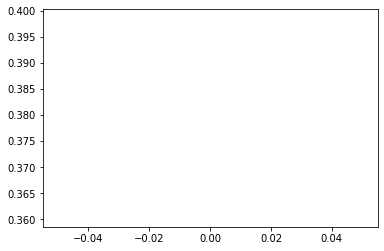

Show next ('n') or quit ('q')?q
quitting...


In [ ]:
# @title Tera's attempt to visualize gabor (not best, use Danny's version)
# %% visualize gabor image

#gab = gaborfit()
for i in range(1,5456+1):  #=1:5456
    test=(gab[:,:,i])  #%+0.5*reshape(stimTrn(10,:,:),[128,128]))./1.5;
    plt.plot(test[-1,1])
    plt.show()
    # plt.title(sprintf('num:%d',i));
    # pause()
    contn = input("Show next ('n') or quit ('q')?")
    if contn == 'n':
        print('showing next...')
        pass
    elif contn == 'q':
        print('quitting...')
        break
    else:
        print('invalid input, breaking loop')
        break